# GAN Concept Demo: Building Blocks of Deepfake Generators

This notebook demonstrates the core components of a Generative Adversarial Network (GAN).  
We define a simple Generator and Discriminator using PyTorch, show the training loop logic, and visualize how adversarial learning works — even if we don't fully train it here.

> 💡 This prepares us for building a real DCGAN in the next step.

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from models.generator import Generator
from models.discriminator import Discriminator

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Define the Generator

The Generator learns to map from a random noise vector (z) to a synthetic image.

In [2]:
# Initialize
generator = Generator().to(device)

## 2. Define the Discriminator

The Discriminator classifies images as real (1) or fake (0).

In [3]:
# Initialize
discriminator = Discriminator().to(device)

## 3. Loss Function & Optimizers

In [4]:
# Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

## 4. Simulate One Training Step

We simulate one batch of real/fake images and show how gradients flow.

In [9]:
# Dummy data: batch of 4, 64x64 RGB images
real_images = torch.randn(4, 3, 64, 64).to(device)
print("Real image shape:", real_images.shape)
batch_size = real_images.size(0)

# Labels
real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

# ----------------------------
# Train Discriminator
# ----------------------------
d_optimizer.zero_grad()

# Real images
pred_real = discriminator(real_images)
loss_real = criterion(pred_real, real_labels)

# Fake images
noise = torch.randn(batch_size, 100).to(device)
print("Noise shape:", noise.shape)
fake_images = generator(noise)
print("Fake image shape:", fake_images.shape)
pred_fake = discriminator(fake_images.detach())  # Detach to stop gradient to G, gradients stop at fake_images — they don’t flow back to the G.
print("Disc output shape:", pred_fake.shape)
loss_fake = criterion(pred_fake, fake_labels)

# Total loss
d_loss = loss_real + loss_fake
d_loss.backward()
d_optimizer.step()

# ----------------------------
# Train Generator
# ----------------------------
g_optimizer.zero_grad()
pred_fake_for_g = discriminator(fake_images)  # Re-run through D
g_loss = criterion(pred_fake_for_g, real_labels)  # Fool D into thinking fake is real
g_loss.backward()
g_optimizer.step()

print(f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Real image shape: torch.Size([4, 3, 64, 64])
Noise shape: torch.Size([4, 100])
Fake image shape: torch.Size([4, 3, 64, 64])
Disc output shape: torch.Size([4, 1])
D Loss: 1.3800, G Loss: 0.7844


## 5. Visualize Generated "Fake" Images (Random Noise → Image)

Even untrained, the generator outputs structured tensors.

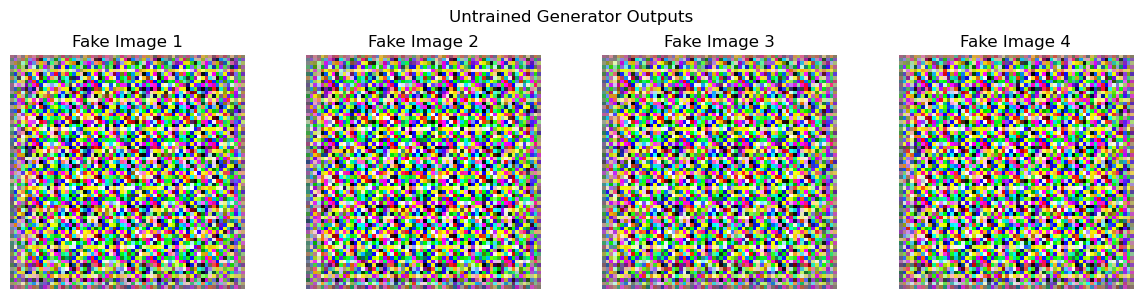

In [10]:
# Generate 4 fake images
with torch.no_grad():
    noise_sample = torch.randn(4, 100).to(device)
    generated_images = generator(noise_sample)

# # Denormalize from [-1, 1] to [0, 1]
# generated_images = (generated_images.cpu() + 1) / 2

# Plot
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = generated_images[i].permute(1, 2, 0).cpu().numpy()
    # axes[i].imshow(np.clip(img, 0, 1))
    # img = np.transpose(generated_images[i].cpu().numpy(), (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())  # Normalize per image
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Fake Image {i+1}")

plt.suptitle("Untrained Generator Outputs")
plt.tight_layout()
plt.show()


---
## 6. Model Summary

Use `torchinfo` to show layer shapes:

In [11]:
# %pip install torchinfo  # install torchinfo if not done yet

from torchinfo import summary

summary(generator, input_size=(1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 64, 64]            --
├─Sequential: 1-1                        [1, 3, 64, 64]            --
│    └─Linear: 2-1                       [1, 16384]                1,654,784
│    └─ReLU: 2-2                         [1, 16384]                --
│    └─Unflatten: 2-3                    [1, 1024, 4, 4]           --
│    └─ConvTranspose2d: 2-4              [1, 512, 8, 8]            8,389,120
│    └─BatchNorm2d: 2-5                  [1, 512, 8, 8]            1,024
│    └─ReLU: 2-6                         [1, 512, 8, 8]            --
│    └─ConvTranspose2d: 2-7              [1, 256, 16, 16]          2,097,408
│    └─BatchNorm2d: 2-8                  [1, 256, 16, 16]          512
│    └─ReLU: 2-9                         [1, 256, 16, 16]          --
│    └─ConvTranspose2d: 2-10             [1, 128, 32, 32]          524,416
│    └─BatchNorm2d: 2-11                 [1, 128, 32, 3

In [12]:
summary(discriminator, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 64, 16, 16]           3,136
│    └─LeakyReLU: 2-2                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 128, 8, 8]            131,200
│    └─BatchNorm2d: 2-4                  [1, 128, 8, 8]            256
│    └─LeakyReLU: 2-5                    [1, 128, 8, 8]            --
│    └─Conv2d: 2-6                       [1, 256, 4, 4]            524,544
│    └─BatchNorm2d: 2-7                  [1, 256, 4, 4]            512
│    └─LeakyReLU: 2-8                    [1, 256, 4, 4]            --
│    └─Conv2d: 2-9                       [1, 512, 2, 2]            2,097,664
│    └─BatchNorm2d: 2-10                 [1, 512, 2, 2]            1,024
│    └─LeakyReLU: 2-11                   [1, 512, 2, 2]     

## ✅ Key Takeaways

- The **Generator** maps noise → image.
- The **Discriminator** learns to distinguish real vs. fake.
- They are trained in **adversarial alternation**.
- Even without full training, the architecture shows how deepfakes are created.

> 🔜 Next: We'll train a real DCGAN on cifar10 / CelebA dataset!